In [1]:
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import os
import random
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
from IPython.display import Audio


## make data

In [3]:
# read la2019 keys file
la19_df = pd.read_csv('/datab/Dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=' ', header=None)
la19_df.columns = ["sid", "utt","phy", "attack", "label"]
la19_df.head

<bound method NDFrame.head of            sid           utt phy attack     label
0      LA_0039  LA_E_2834763   -    A11     spoof
1      LA_0014  LA_E_8877452   -    A14     spoof
2      LA_0040  LA_E_6828287   -    A16     spoof
3      LA_0022  LA_E_6977360   -    A09     spoof
4      LA_0031  LA_E_5932896   -    A13     spoof
...        ...           ...  ..    ...       ...
71232  LA_0004  LA_E_1665632   -      -  bonafide
71233  LA_0038  LA_E_5085671   -    A09     spoof
71234  LA_0012  LA_E_4926022   -    A16     spoof
71235  LA_0052  LA_E_2894498   -      -  bonafide
71236  LA_0009  LA_E_4689563   -    A19     spoof

[71237 rows x 5 columns]>

In [9]:
# duplicate the data
la19_df_dup = la19_df.copy()
la19_df_dup['utt'] = la19_df_dup['utt'] + '_decoded'
la19_df_dup.head


<bound method NDFrame.head of            sid                   utt phy attack     label
0      LA_0039  LA_E_2834763_decoded   -    A11     spoof
1      LA_0014  LA_E_8877452_decoded   -    A14     spoof
2      LA_0040  LA_E_6828287_decoded   -    A16     spoof
3      LA_0022  LA_E_6977360_decoded   -    A09     spoof
4      LA_0031  LA_E_5932896_decoded   -    A13     spoof
...        ...                   ...  ..    ...       ...
71232  LA_0004  LA_E_1665632_decoded   -      -  bonafide
71233  LA_0038  LA_E_5085671_decoded   -    A09     spoof
71234  LA_0012  LA_E_4926022_decoded   -    A16     spoof
71235  LA_0052  LA_E_2894498_decoded   -      -  bonafide
71236  LA_0009  LA_E_4689563_decoded   -    A19     spoof

[71237 rows x 5 columns]>

In [10]:
# write to protocol file have the structure: utt.wav eval label
with open('protocol.txt', 'w') as f:
    for i in tqdm(range(len(la19_df))):
        f.write('la19_eval/'+la19_df.iloc[i]['utt'] + '.wav eval ' + la19_df.iloc[i]['label'] + '\n')

    for i in tqdm(range(len(la19_df_dup))):
        f.write('la19_eval_lyra/'+la19_df_dup.iloc[i]['utt'] + '.wav eval ' + la19_df_dup.iloc[i]['label'] + '\n')


100%|██████████| 71237/71237 [00:10<00:00, 6757.15it/s]


## result

In [2]:
la19_lyra_df = pd.read_csv('protocol.txt', sep=' ', header=None)
la19_lyra_df.columns = ["utt", "subset","label"]
la19_lyra_df.head

<bound method NDFrame.head of                                             utt subset     label
0                    la19_eval/LA_E_2834763.wav   eval     spoof
1                    la19_eval/LA_E_8877452.wav   eval     spoof
2                    la19_eval/LA_E_6828287.wav   eval     spoof
3                    la19_eval/LA_E_6977360.wav   eval     spoof
4                    la19_eval/LA_E_5932896.wav   eval     spoof
...                                         ...    ...       ...
142469  la19_eval_lyra/LA_E_1665632_decoded.wav   eval  bonafide
142470  la19_eval_lyra/LA_E_5085671_decoded.wav   eval     spoof
142471  la19_eval_lyra/LA_E_4926022_decoded.wav   eval     spoof
142472  la19_eval_lyra/LA_E_2894498_decoded.wav   eval  bonafide
142473  la19_eval_lyra/LA_E_4689563_decoded.wav   eval     spoof

[142474 rows x 3 columns]>

### la19_lyra_1e-07_3a_augall_la2019_lyra_epoch_35.txt

EER: 14.5721%, threshold: -0.0011


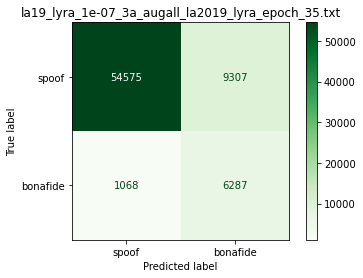

In [8]:
pred_df = pd.read_csv("../../Supcon-voco/docs/la19_lyra_1e-07_3a_augall_la2019_lyra_epoch_35.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

la19_lyra_df['utt'] = la19_lyra_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(la19_lyra_df, pred_df, on='utt')
res_df = res_df[res_df['utt'].str.contains('decoded')]

# res_df = res_df[res_df['subset'] == 'eval']
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("la19_lyra_1e-07_3a_augall_la2019_lyra_epoch_35.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

-0.0008531744824722 -7.048083305358887


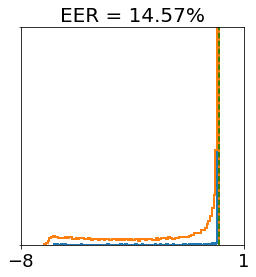

In [7]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1, int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


### la19_lyra_1e-07_3_augall_asvspoof2019_linear_nll_2l_epoch_46.txt

EER: 1.9957%, threshold: -0.0009


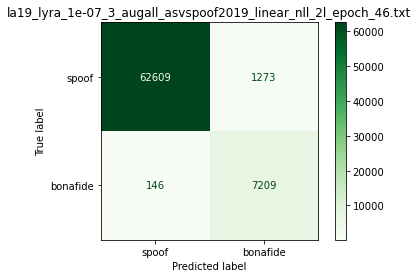

In [4]:
pred_df = pd.read_csv("../../Supcon-voco/docs/la19_lyra_1e-07_3_augall_asvspoof2019_linear_nll_2l_epoch_46.txt", sep=" ", header=None)
pred_df.columns = ["utt", "score"]

la19_lyra_df['utt'] = la19_lyra_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(la19_lyra_df, pred_df, on='utt')
res_df = res_df[~res_df['utt'].str.contains('decoded')]

# res_df = res_df[res_df['subset'] == 'eval']
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("la19_lyra_1e-07_3_augall_asvspoof2019_linear_nll_2l_epoch_46.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

-0.0007784912013448 -7.515649318695068


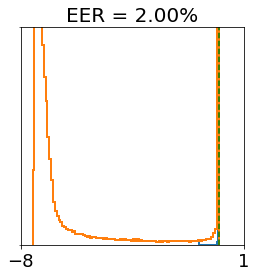

In [5]:
import matplotlib.pyplot as plt
import numpy as np

max_score = max(res_df['score'])
min_score = min(res_df['score'])
print(max_score, min_score)

plt.figure(figsize=(4, 4))
bona = res_df[(res_df['label'] == 'bonafide')]['score']
spoof = res_df[(res_df['label'] == 'spoof')]['score']

# Plotting the distributions as line chart histograms
plt.hist(bona, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Bonafide')
plt.hist(spoof, bins=100, density=True, cumulative=False, histtype='step', linewidth=2, label='Spoofing')


# Adding labels and title
# plt.xlabel('Scores', fontsize=20)
# plt.ylabel('score probability density plot')
plt.title('EER = {:.2f}%'.format(eer*100), fontsize=20)


# yaxis logit scale
plt.yscale('symlog')


# Adding a legend
# plt.legend(loc='lower right')
# Adding vertical lines
plt.axvline(x=threshold, color='g', linestyle='--', linewidth=1.5)

# Set the x-axis tick positions and labels
plt.xticks([int(min_score)-1, int(max_score)+1], fontsize=18)
plt.yticks([])
plt.ylim(0,1)
# save fig
# plt.savefig("figs/aasist-df.pdf", dpi=600)
# Displaying the plot
plt.show()


In [9]:
score_la19 = res_df[~res_df['utt'].str.contains('decoded')].copy()
score_lyra = res_df[res_df['utt'].str.contains('decoded')].copy()
score_lyra['utt']=score_lyra['utt'].apply(lambda x: x.replace('_decoded', ''))

In [10]:
score_lyra.head

<bound method NDFrame.head of                  utt subset     label     score      pred
71237   LA_E_2834763   eval     spoof -6.878593  bonafide
71238   LA_E_8877452   eval     spoof -7.464682     spoof
71239   LA_E_6828287   eval     spoof -5.773494  bonafide
71240   LA_E_6977360   eval     spoof -7.145051  bonafide
71241   LA_E_5932896   eval     spoof -7.460688     spoof
...              ...    ...       ...       ...       ...
142469  LA_E_1665632   eval  bonafide -6.977233  bonafide
142470  LA_E_5085671   eval     spoof -7.439640     spoof
142471  LA_E_4926022   eval     spoof -7.426030     spoof
142472  LA_E_2894498   eval  bonafide -7.391605     spoof
142473  LA_E_4689563   eval     spoof -7.403700     spoof

[71237 rows x 5 columns]>

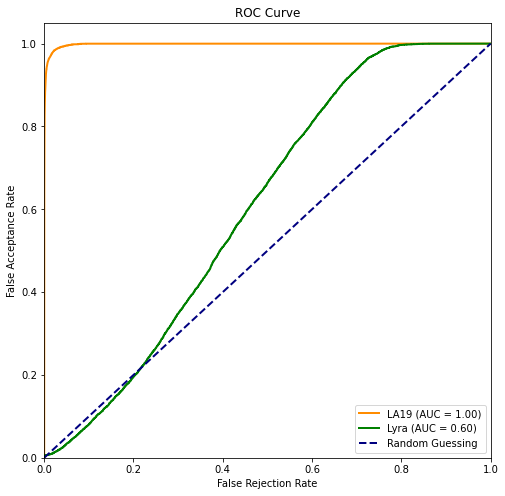

In [12]:
# plot ROC curve of la19 and lyra
from sklearn.metrics import roc_curve, auc
fpr_la19, tpr_la19, thresholds_la19 = roc_curve(score_la19['label'], score_la19['score'], pos_label='bonafide')
fpr_lyra, tpr_lyra, thresholds_lyra = roc_curve(score_lyra['label'], score_lyra['score'], pos_label='bonafide')
roc_auc_la19 = auc(fpr_la19, tpr_la19)
roc_auc_lyra = auc(fpr_lyra, tpr_lyra)
plt.figure(figsize=(8, 8))
plt.plot(fpr_la19, tpr_la19, color='darkorange', lw=2, label='LA19 (AUC = %0.2f)' % roc_auc_la19)
plt.plot(fpr_lyra, tpr_lyra, color='green', lw=2, label='Lyra (AUC = %0.2f)' % roc_auc_lyra)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Rejection Rate')
plt.ylabel('False Acceptance Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
# plt.savefig("figs/roc.png", dpi=300)
plt.show()

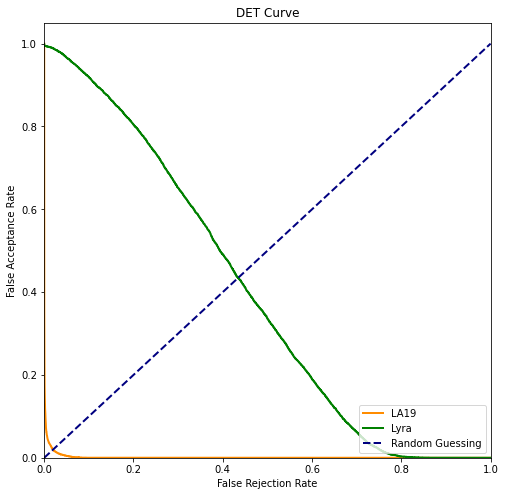

In [13]:
# plot DET curve of la19 and lyra
from scipy.interpolate import interp1d
fnr_la19 = 1 - tpr_la19
fnr_lyra = 1 - tpr_lyra
fnr_interp_la19 = interp1d(fpr_la19, fnr_la19)
fnr_interp_lyra = interp1d(fpr_lyra, fnr_lyra)
plt.figure(figsize=(8, 8))
plt.plot(fpr_la19, fnr_la19, color='darkorange', lw=2, label='LA19')
plt.plot(fpr_lyra, fnr_lyra, color='green', lw=2, label='Lyra')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Rejection Rate')
plt.ylabel('False Acceptance Rate')
plt.title('DET Curve')
plt.legend(loc="lower right")
# plt.savefig("figs/det.png", dpi=300)
plt.show()